## Performance Diagnostics and Optimization Strategy
Throughout this process I will be tracking and plotting recall, loss, and accuracy as the key performance indicators. I will be more concerned with recall than with accuracy, because it is most important that the model captures as many of the true postives (cases of pneumonia) as possible, rather than how often any given prediction is correct (i.e. accuracy). This is because this model would be used and a medical diagnostics role and false positives can be easily cross-examined with other means, but it would be a major risk to allow true positives to *slip through the cracks* so-to-sepeak. It would be better to take a bit longer to validate negative cases and not miss any positive cases, than to correctly predict positive or negative *most of the time*.

- First I will compile and train a simple [Baseline Model](#baseline-model)
- Second I will sophisticate the [model architecture](#sophisticating-model-architecture), and the parameters of the [fit function](#sophisticating-the-training-protocol)
- The next step will be to [regularize the network](#network-regularization)



In [1]:
# visualizes accuracy and loss accross training epochs
import matplotlib.pyplot as plt

def visualize_training(model,recall_num:None):

    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    recall = model.history['recall'+recall_num]
    val_recall = model.history['val_recall'+recall_num]
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')

    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')

    plt.legend()
    plt.figure()

    plt.plot(epochs, recall, 'bo', label='Training recall')
    plt.plot(epochs, val_recall, 'b', label='Validation recall')
    plt.title('Training and validation recall')

    plt.legend()
    plt.show()

## Generate Data

In [2]:
# dependences for data loading and sifting
import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [3]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

In [4]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=8,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=8,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=8,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Baseline Model
Beginning a convolutional neural network with the most simple architecture for the sake of efficient diagnostics and optimization.  

In [5]:
from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall

The architecture begins with a convolutional 2D layers, followed by a pooling layer, flattened, and then followed up with two dense layers.  
THe model is compiled using binary cross entropy to measure the loss function and accuracy foor the performance metric.

In [6]:

# Your code here; design and compile the model
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))


base_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

the compiled base model is now fit very lean, using 10 steps per epoch and 5 total epochs, the test data set is used for validation as the actual validation sample is extremely small and reserved only for the final phase of performance evaluation. 

In [7]:
base_model_results = base_model.fit(train_data_generator, 
                              steps_per_epoch=20, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
20/20 [==============================] - 19s 962ms/step - loss: 10.1371 - acc: 0.5938 - recall: 0.7345 - val_loss: 3.2296 - val_acc: 0.3833 - val_recall: 0.0000e+00
Epoch 2/5
20/20 [==============================] - 17s 849ms/step - loss: 1.7071 - acc: 0.6812 - recall: 0.7692 - val_loss: 3.6348 - val_acc: 0.6333 - val_recall: 1.0000
Epoch 3/5
20/20 [==============================] - 17s 855ms/step - loss: 0.8722 - acc: 0.7437 - recall: 0.8607 - val_loss: 0.3944 - val_acc: 0.8083 - val_recall: 0.9324
Epoch 4/5
20/20 [==============================] - 19s 967ms/step - loss: 0.3774 - acc: 0.8562 - recall: 0.9350 - val_loss: 0.3361 - val_acc: 0.8833 - val_recall: 0.9437
Epoch 5/5
20/20 [==============================] - 21s 1s/step - loss: 0.2081 - acc: 0.9125 - recall: 0.9640 - val_loss: 0.4214 - val_acc: 0.8250 - val_recall: 0.9692


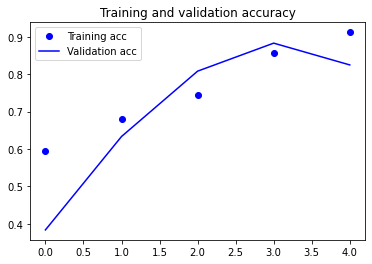

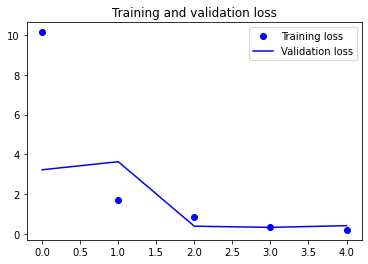

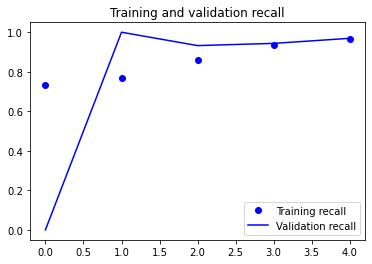

In [8]:
visualize_training(base_model_results,"")

The base model begins stronger than expected with an accuracy of around 70% on the test data (sometimes better or worse, re-running the cell multiple times). A good start, with plenty of room to improve. 

## Sophisticating model architecture

Before exploring tuning and optimization of hyperparameters and other methods such as regularization, we will sophisticate the architectuer of the model itself by incorporating more layers in a variety of types including convolutional layers, pooling layers, and dense layers. 

In [9]:
deep_model = models.Sequential()

deep_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Flatten())
deep_model.add(layers.Dense(512, activation='relu'))
deep_model.add(layers.Dense(256, activation='relu'))
deep_model.add(layers.Dense(1, activation='sigmoid'))

deep_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [13]:
deep_model_results = deep_model.fit(train_data_generator, 
                              steps_per_epoch=20, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
20/20 [==============================] - 11s 549ms/step - loss: 0.0973 - acc: 0.9438 - recall_1: 0.9667 - val_loss: 1.1809 - val_acc: 0.8200 - val_recall_1: 0.9833
Epoch 2/5
20/20 [==============================] - 13s 636ms/step - loss: 0.2200 - acc: 0.9563 - recall_1: 0.9664 - val_loss: 1.8142 - val_acc: 0.7300 - val_recall_1: 1.0000
Epoch 3/5
20/20 [==============================] - 12s 580ms/step - loss: 0.0671 - acc: 0.9750 - recall_1: 0.9831 - val_loss: 1.2032 - val_acc: 0.8150 - val_recall_1: 0.9917
Epoch 4/5
20/20 [==============================] - 11s 548ms/step - loss: 0.1379 - acc: 0.9563 - recall_1: 0.9597 - val_loss: 1.3176 - val_acc: 0.7100 - val_recall_1: 0.9922
Epoch 5/5
20/20 [==============================] - 11s 538ms/step - loss: 0.1214 - acc: 0.9688 - recall_1: 0.9843 - val_loss: 1.8911 - val_acc: 0.7050 - val_recall_1: 1.0000


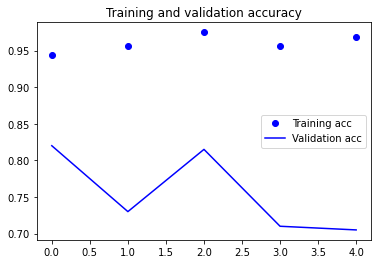

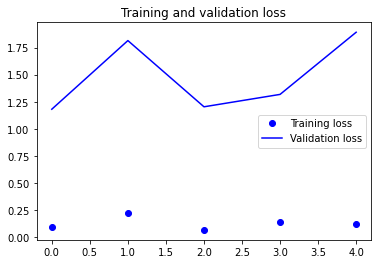

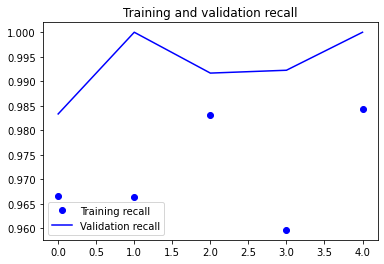

In [14]:
visualize_training(deep_model_results,"_1")

## sophisticating the training protocol

The deeper model's final results and history (visualized above) is showing clear signs of overfitting. The next step I will take is sophisticating the parameters of the fit function being used. My intuition is that the fit function is too simple relative to the complexity of the model architecture. 

In [15]:
fitter_model_results = deep_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/15
50/50 [==============================] - 20s 394ms/step - loss: 0.1660 - acc: 0.9400 - recall_1: 0.9575 - val_loss: 1.2034 - val_acc: 0.7650 - val_recall_1: 1.0000
Epoch 2/15
50/50 [==============================] - 23s 463ms/step - loss: 0.1716 - acc: 0.9575 - recall_1: 0.9661 - val_loss: 1.1705 - val_acc: 0.8300 - val_recall_1: 0.9854
Epoch 3/15
50/50 [==============================] - 21s 426ms/step - loss: 0.1386 - acc: 0.9600 - recall_1: 0.9764 - val_loss: 1.3639 - val_acc: 0.7400 - val_recall_1: 1.0000
Epoch 4/15
50/50 [==============================] - 23s 461ms/step - loss: 0.1435 - acc: 0.9650 - recall_1: 0.9736 - val_loss: 1.6290 - val_acc: 0.6300 - val_recall_1: 1.0000
Epoch 5/15
50/50 [==============================] - 33s 655ms/step - loss: 0.0957 - acc: 0.9650 - recall_1: 0.9764 - val_loss: 4.6109 - val_acc: 0.6500 - val_recall_1: 1.0000
Epoch 6/15
50/50 [==============================] - 35s 708ms/step - loss: 0.1139 - acc: 0.9650 - recall_1: 0.9859 - val_loss

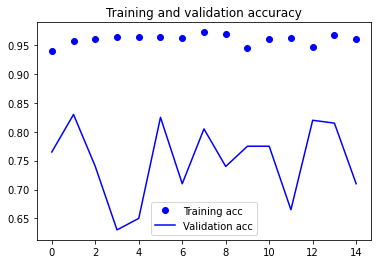

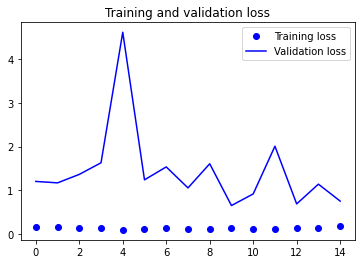

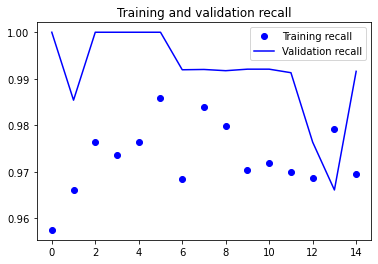

In [16]:
visualize_training(fitter_model_results,"_1")

The accuracy and loss on training data is begining to behave more as desired; however on the test data the history is still quite eratic indicating that the model is still overfitting and not able to generalize consistently. All that considered the final accuracy on the training data is the best so far so we're moving in the right direction.

## Network Regularization

### L2 regularization
I will begin regularizing the network by incorporating L2 regularization on the dense layers of the existing model architecture

In [6]:
from keras.regularizers import l2


In [18]:

L2_model = models.Sequential()

L2_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Flatten())
L2_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(1, activation='sigmoid'))

L2_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [19]:
# added 5 epochs from the last fit call
L2_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/20
50/50 [==============================] - 25s 491ms/step - loss: 2.0316 - acc: 0.7125 - recall_2: 0.9040 - val_loss: 1.0461 - val_acc: 0.6000 - val_recall_2: 1.0000
Epoch 2/20
50/50 [==============================] - 22s 435ms/step - loss: 0.8472 - acc: 0.7900 - recall_2: 0.9283 - val_loss: 0.8025 - val_acc: 0.7950 - val_recall_2: 0.9683
Epoch 3/20
50/50 [==============================] - 22s 436ms/step - loss: 0.5542 - acc: 0.8550 - recall_2: 0.9125 - val_loss: 0.6984 - val_acc: 0.7800 - val_recall_2: 0.9504
Epoch 4/20
50/50 [==============================] - 23s 468ms/step - loss: 0.4772 - acc: 0.8650 - recall_2: 0.9195 - val_loss: 0.7631 - val_acc: 0.7450 - val_recall_2: 0.9538
Epoch 5/20
50/50 [==============================] - 25s 494ms/step - loss: 0.4328 - acc: 0.8900 - recall_2: 0.9384 - val_loss: 0.8862 - val_acc: 0.6950 - val_recall_2: 1.0000
Epoch 6/20
50/50 [==============================] - 23s 463ms/step - loss: 0.3845 - acc: 0.8975 - recall_2: 0.9412 - val_loss

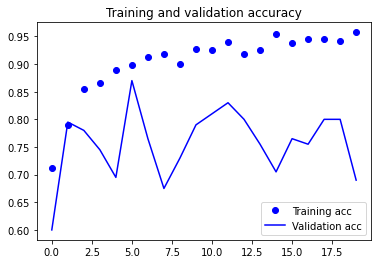

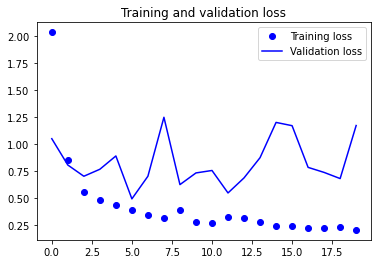

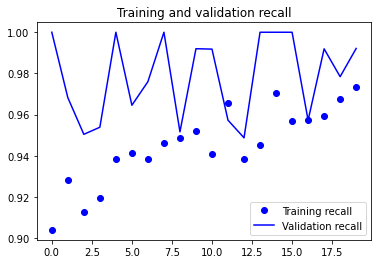

In [20]:
visualize_training(L2_model_results,"_2")

L2 regularization appears to have resolved overfitting at least as far a recall is concerned. The recall is nearly perfect, however the validation loss is very high, considering this alongside that validation accuracy tends to hangout around 75%, my interpretation is that the model is predicting almost all true positive cases, while also making a considrable amount of false positive predictions. This is exactly the behaviour I am looking for. The recall is well within an acceptable margin; in the interest of the end user however (i.e. the medical profesionals) I want to reduce the rate of false positives. This would reduce the amount of manual human effort required to validate diagnoses made by the model saving both time and money for both patients and service providers.  

### Dropout regularization
The most common practice with dropout regularization of CNNs is including a dropout layer after each fully connected (Dense) layer. So the next step will be adding two dropout layers each with a value of 0.3, after each of the two hidden Dense layers. There will be no dropout incorporated with the output layer.

In [21]:
dropout_model = models.Sequential()

dropout_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(1, activation='sigmoid'))

dropout_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [22]:
dropout_model_results = dropout_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

Epoch 1/20
50/50 [==============================] - 27s 537ms/step - loss: 1.8572 - acc: 0.7350 - recall_3: 0.8944 - val_loss: 1.1915 - val_acc: 0.7100 - val_recall_3: 0.9756
Epoch 2/20
50/50 [==============================] - 27s 536ms/step - loss: 0.8444 - acc: 0.8050 - recall_3: 0.9169 - val_loss: 0.8049 - val_acc: 0.6650 - val_recall_3: 0.9677
Epoch 3/20
50/50 [==============================] - 25s 509ms/step - loss: 0.5898 - acc: 0.8450 - recall_3: 0.9318 - val_loss: 0.8366 - val_acc: 0.7050 - val_recall_3: 0.9926
Epoch 4/20
50/50 [==============================] - 28s 560ms/step - loss: 0.5075 - acc: 0.8950 - recall_3: 0.9541 - val_loss: 0.7207 - val_acc: 0.7400 - val_recall_3: 1.0000
Epoch 5/20
50/50 [==============================] - 26s 517ms/step - loss: 0.4199 - acc: 0.9150 - recall_3: 0.9592 - val_loss: 0.8899 - val_acc: 0.7300 - val_recall_3: 0.9520
Epoch 6/20
50/50 [==============================] - 39s 778ms/step - loss: 0.4233 - acc: 0.9000 - recall_3: 0.9247 - val_loss

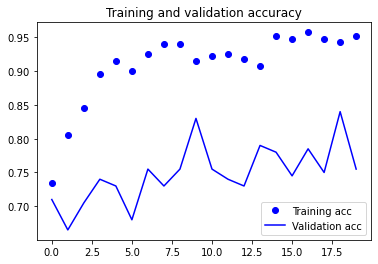

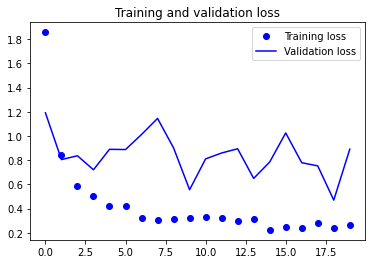

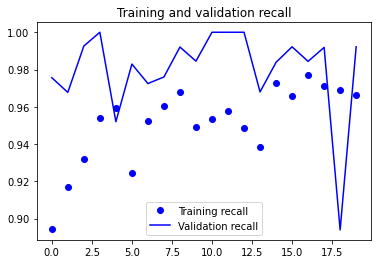

In [23]:
visualize_training(dropout_model_results,"_3")

Performance on validation data is still quite eradic, and it appears to have probably worsened recall as well as loss. I will continue with the L2_model and leave alone the dropout_model. 

## Gradient Descent Optimization and Learning Rate
So far, a optimizer has not been specified in the model compiler. Below I will test 3 different optimization algorithms, and then will experiment with the learning rate of the best performing algorithm to improve it further. **I will be using a leaner fit function protocol here in the interest of time.**  
The optimizers being test are:
- Stochastic Gradient Descent (SGD)
- Adaptive Momenmt Estimation (Adam)
- Adaptive Delta (Adadelta)

In [24]:
L2_model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['acc',Recall()])

SGD_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/5
25/25 [==============================] - 11s 430ms/step - loss: 0.2765 - acc: 0.9250 - recall_4: 0.9726 - val_loss: 0.7587 - val_acc: 0.7625 - val_recall_4: 1.0000
Epoch 2/5
25/25 [==============================] - 14s 540ms/step - loss: 0.2516 - acc: 0.9400 - recall_4: 0.9682 - val_loss: 0.7568 - val_acc: 0.7250 - val_recall_4: 0.9811
Epoch 3/5
25/25 [==============================] - 14s 563ms/step - loss: 0.2236 - acc: 0.9500 - recall_4: 0.9605 - val_loss: 1.1625 - val_acc: 0.6750 - val_recall_4: 1.0000
Epoch 4/5
25/25 [==============================] - 13s 533ms/step - loss: 0.1957 - acc: 0.9500 - recall_4: 0.9801 - val_loss: 0.6786 - val_acc: 0.7875 - val_recall_4: 0.9800
Epoch 5/5
25/25 [==============================] - 13s 515ms/step - loss: 0.2867 - acc: 0.9100 - recall_4: 0.9533 - val_loss: 1.1055 - val_acc: 0.7125 - val_recall_4: 1.0000


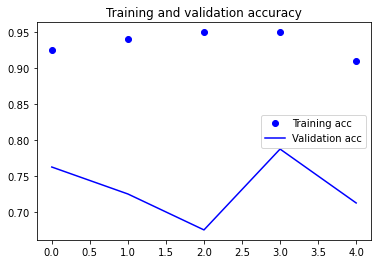

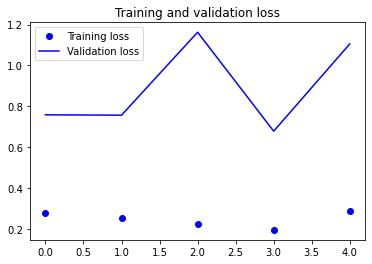

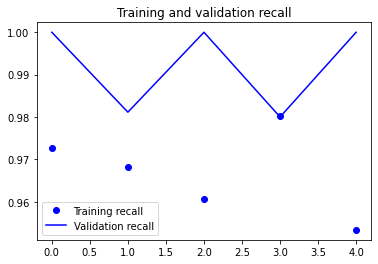

In [25]:
visualize_training(SGD_model_results,"_4")

In [26]:
L2_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

Adam_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/5
25/25 [==============================] - 11s 448ms/step - loss: 0.2051 - acc: 0.9450 - recall_5: 0.9804 - val_loss: 0.6442 - val_acc: 0.7625 - val_recall_5: 0.9434
Epoch 2/5
25/25 [==============================] - 11s 451ms/step - loss: 0.2490 - acc: 0.9150 - recall_5: 0.9412 - val_loss: 0.6225 - val_acc: 0.7875 - val_recall_5: 1.0000
Epoch 3/5
25/25 [==============================] - 10s 411ms/step - loss: 0.1877 - acc: 0.9500 - recall_5: 0.9595 - val_loss: 1.3738 - val_acc: 0.6750 - val_recall_5: 1.0000
Epoch 4/5
25/25 [==============================] - 10s 417ms/step - loss: 0.2121 - acc: 0.9400 - recall_5: 0.9732 - val_loss: 0.6171 - val_acc: 0.8250 - val_recall_5: 1.0000
Epoch 5/5
25/25 [==============================] - 10s 416ms/step - loss: 0.1485 - acc: 0.9800 - recall_5: 0.9864 - val_loss: 0.7142 - val_acc: 0.8125 - val_recall_5: 1.0000


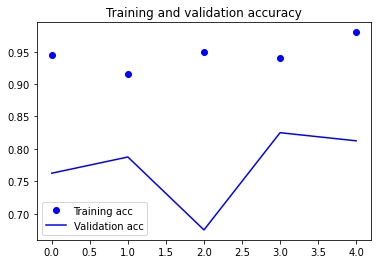

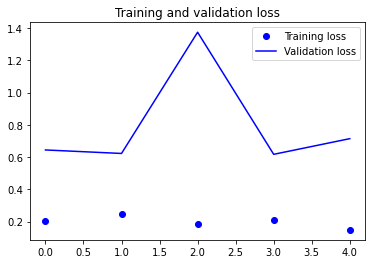

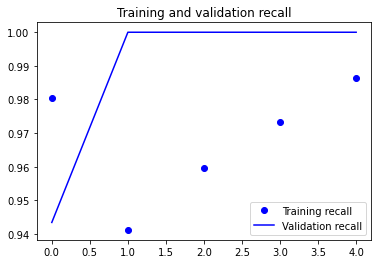

In [27]:
visualize_training(Adam_model_results,"_5")

In [28]:
L2_model.compile(optimizer='Adadelta',
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

Adadelta_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/5
25/25 [==============================] - 10s 400ms/step - loss: 0.1506 - acc: 0.9750 - recall_6: 0.9867 - val_loss: 1.0428 - val_acc: 0.7625 - val_recall_6: 1.0000
Epoch 2/5
25/25 [==============================] - 9s 373ms/step - loss: 0.1540 - acc: 0.9650 - recall_6: 0.9686 - val_loss: 1.1547 - val_acc: 0.7500 - val_recall_6: 1.0000
Epoch 3/5
25/25 [==============================] - 9s 366ms/step - loss: 0.1226 - acc: 0.9750 - recall_6: 0.9859 - val_loss: 0.8595 - val_acc: 0.8000 - val_recall_6: 1.0000
Epoch 4/5
25/25 [==============================] - 9s 380ms/step - loss: 0.1798 - acc: 0.9550 - recall_6: 0.9786 - val_loss: 0.8289 - val_acc: 0.8000 - val_recall_6: 1.0000
Epoch 5/5
25/25 [==============================] - 9s 379ms/step - loss: 0.1818 - acc: 0.9500 - recall_6: 0.9660 - val_loss: 0.9803 - val_acc: 0.7750 - val_recall_6: 1.0000


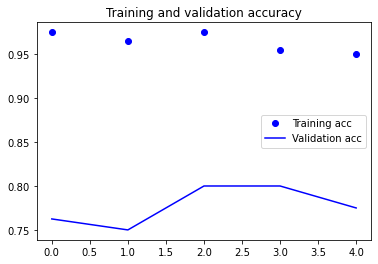

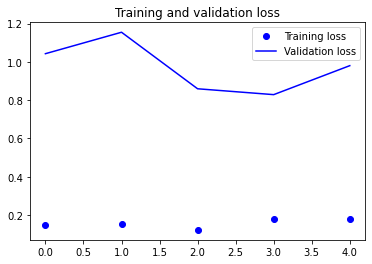

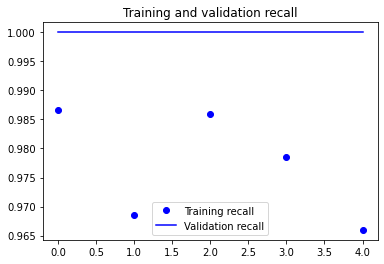

In [29]:
visualize_training(Adadelta_model_results,"_6")

None of the above performed obviously better than the other, but rather there appears to be trade-offs between the three, and the high loss value is still an issue. However I am deciding to continue investigating with the Adam optimizer because its loss function has the strongest downarsd trend among the three, its accuracy continually improves, and the recall although behaving oddly at this point remains within a reasonable range of 1.0 even at its lowest.  

It will be interesting to see how the learning rate affects Adams recall as well how a more robust fit function may help as well. The recall in the above plot seems to decrease over epochs, maybe more epochs are needed or maybe early stoppage would help as well. 

### Learning Rate and Early Stoppage with Adaptive Momentum Optimization

In [33]:
adam_model = models.Sequential()

adam_model.add(layers.Conv2D(8,(3,3),activation='relu',input_shape=(150,150,1)))
adam_model.add(layers.MaxPooling2D((2, 2)))
adam_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
adam_model.add(layers.MaxPooling2D((2, 2)))
adam_model.add(layers.Flatten())
adam_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
adam_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
adam_model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
adam_01 = optimizers.Adam(learning_rate=0.01)
adam_model.compile(optimizer=adam_01,
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [38]:
Adam_01_model_results = adam_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=10, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/10
50/50 [==============================] - 10s 203ms/step - loss: 0.6562 - acc: 0.7625 - recall_6: 1.0000 - val_loss: 0.7915 - val_acc: 0.6125 - val_recall_6: 1.0000
Epoch 2/10
50/50 [==============================] - 9s 186ms/step - loss: 0.6546 - acc: 0.7425 - recall_6: 1.0000 - val_loss: 0.6589 - val_acc: 0.7250 - val_recall_6: 1.0000
Epoch 3/10
50/50 [==============================] - 9s 181ms/step - loss: 0.6182 - acc: 0.7550 - recall_6: 1.0000 - val_loss: 0.7319 - val_acc: 0.6500 - val_recall_6: 1.0000
Epoch 4/10
50/50 [==============================] - 9s 173ms/step - loss: 0.6139 - acc: 0.7475 - recall_6: 1.0000 - val_loss: 0.6265 - val_acc: 0.7250 - val_recall_6: 1.0000
Epoch 5/10
50/50 [==============================] - 9s 181ms/step - loss: 0.6061 - acc: 0.7425 - recall_6: 1.0000 - val_loss: 0.7168 - val_acc: 0.6250 - val_recall_6: 1.0000
Epoch 6/10
50/50 [==============================] - 9s 183ms/step - loss: 0.5998 - acc: 0.7400 - recall_6: 1.0000 - val_loss: 0.7

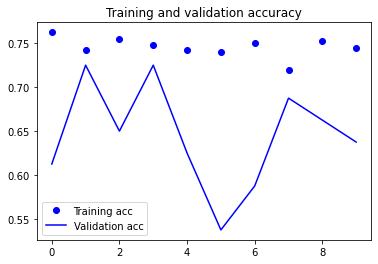

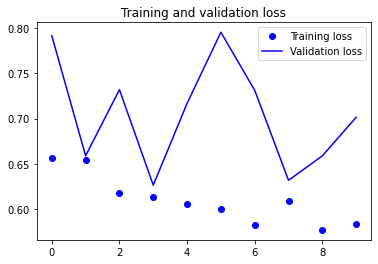

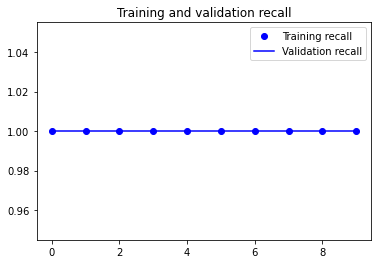

In [39]:
visualize_training(Adam_01_model_results,"_6")

Recall seems to be right at home with this model architecture, however there is still some progress to be made regarding loss. Improving the loss function should reduce the false positive rate, making the tool more effective to the end user. Next I will rerun the above model using early stoppage monitoring the loss function. 

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
early_stopping = [EarlyStopping(monitor='val_loss',patience=5),
                  ModelCheckpoint(filepath='data/final_model.h5',monitor='val_loss',save_best_only=True)]

In [43]:
final_model_results = adam_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=50,
                                        callbacks=early_stopping, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

Epoch 1/50
50/50 [==============================] - 11s 219ms/step - loss: 0.5550 - acc: 0.7625 - recall_6: 1.0000 - val_loss: 0.6689 - val_acc: 0.6500 - val_recall_6: 1.0000
Epoch 2/50
50/50 [==============================] - 10s 202ms/step - loss: 0.5627 - acc: 0.7550 - recall_6: 1.0000 - val_loss: 0.7576 - val_acc: 0.5750 - val_recall_6: 1.0000
Epoch 3/50
50/50 [==============================] - 10s 200ms/step - loss: 0.5873 - acc: 0.7300 - recall_6: 1.0000 - val_loss: 0.7447 - val_acc: 0.5750 - val_recall_6: 1.0000
Epoch 4/50
50/50 [==============================] - 10s 201ms/step - loss: 0.5776 - acc: 0.7400 - recall_6: 1.0000 - val_loss: 0.5643 - val_acc: 0.7500 - val_recall_6: 1.0000
Epoch 5/50
50/50 [==============================] - 10s 195ms/step - loss: 0.5738 - acc: 0.7450 - recall_6: 1.0000 - val_loss: 0.6584 - val_acc: 0.6750 - val_recall_6: 1.0000
Epoch 6/50
50/50 [==============================] - 10s 191ms/step - loss: 0.5671 - acc: 0.7525 - recall_6: 1.0000 - val_loss

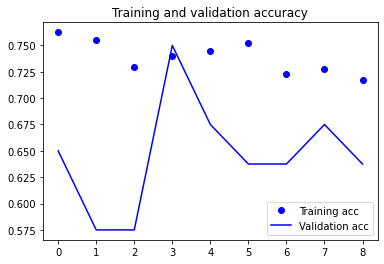

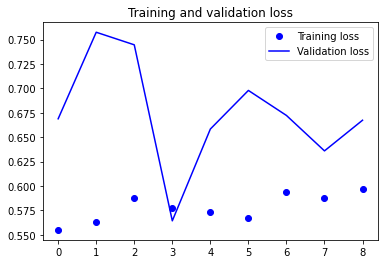

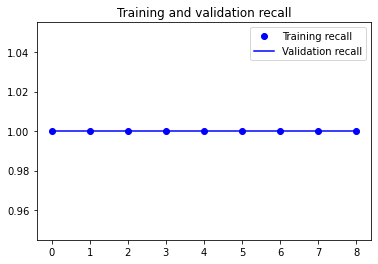

In [44]:
visualize_training(final_model_results,"_6")

In [46]:
from keras.models import load_model
saved_model =  load_model('data/final_model.h5')

In [47]:
results_train = saved_model.evaluate(train_data_generator)
print(f'Training Recall: {results_train[2]:.3} \nTraining Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(test_data_generator)
print(f'Test Recall: {results_test[2]:.3} \nTest Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_data_generator)
print(f'Validation Recall: {results_val[2]:.3} \nValidation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

652/652 [==============================] - 74s 113ms/step - loss: 0.5715 - acc: 0.7429 - recall_6: 1.0000
Training Recall: 1.0 
Training Loss: 0.572 
Training Accuracy: 0.743
----------
78/78 [==============================] - 8s 102ms/step - loss: 0.6905 - acc: 0.6250 - recall_6: 1.00002s - l
Test Recall: 1.0 
Test Loss: 0.691 
Test Accuracy: 0.625
----------
2/2 [==============================] - 0s 65ms/step - loss: 0.8168 - acc: 0.5000 - recall_6: 1.0000
Validation Recall: 1.0 
Validation Loss: 0.817 
Validation Accuracy: 0.5
